## 用TensorFlow并行训练神经网络
pip install tensorflow -i https://pypi.tuna.tsinghua.edu.cn/simple

In [3]:
import tensorflow.compat.v1 as tf  #使用1.0版本的tensorflow

#tf.disable_v2_behavior()
#tf.compat.v1.disable_eager_execution()

tf.__version__

'2.8.0'

## 底层API的使用

In [4]:
#计算z=w*x+b
g = tf.Graph()
#创建一个计算图
with g.as_default():
    #创建一个变量占位符
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None),
                       name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w * x + b
    init = tf.global_variables_initializer()  #含有tf.Variable的环境下，因为tf中建立的变量是没有初始化的，也就是在debug时还不是一个tensor量，而是一个Variable变量类型
with tf.Session(graph=g) as sess:
    sess.run(init)  #初始化计算图一遍
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f -->z=%4.1f' % (t, sess.run(z, feed_dict={x: t})))  #传入对应的x对应的值

x= 1.0 -->z= 2.7
x= 0.6 -->z= 1.9
x=-1.8 -->z=-2.9


2022-05-08 14:32:31.139786: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#计算阵列结构的张量
import numpy as np

g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None, 2, 3),
                       name="input_x")
    x2 = tf.reshape(x, shape=(-1, 6),  #数组转换为6列
                    name="x2")
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')  #计算列和
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')  #计算列均值
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print(x_array)
    print('input shape: ', x_array.shape)
    print('Reshaped:\n',
          sess.run(x2, feed_dict={x: x_array}))
    print('Column Sums:\n',
          sess.run(xsum, feed_dict={x: x_array}))
    print('Column Means:\n',
          sess.run(xmean, feed_dict={x: x_array}))

[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
input shape:  (3, 2, 3)
Reshaped:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


## 使用底层API实现最小二乘估计

In [20]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1, 1.3, 3.1, 2, 5, 6.3, 6.6, 7.4, 8, 9])


class TfLinreg(object):
    def __init__(self, x_dim, learning_rate=1.0, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        #创建一个计算图
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()

    def build(self):
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=(None, self.x_dim),
                                name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                                shape=(None),
                                name='y_input')
        print(self.X)
        print(self.y)
        w = tf.Variable(tf.zeros(shape=(1)),
                        name='weight')
        b = tf.Variable(tf.zeros(shape=(1)),
                        name="bias")
        print(w)
        print(b)
        self.z_net = tf.squeeze(w * self.X + b,  #删除维度为1的张量
                                name='z_net')
        print(self.z_net)
        sqr_errors = tf.square(self.y - self.z_net,
                               name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors,
                                        name='mean_cost')
        optimizer = tf.train.GradientDescentOptimizer(  #使用梯度下降
            learning_rate=self.learning_rate,
            name='GradientDescent'
        )
        self.optimizer = optimizer.minimize(self.mean_cost)  #计算梯度，并自动更新参数

In [21]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(None, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32>
<tf.Variable 'bias:0' shape=(1,) dtype=float32>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [22]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    #初始化所有的变量w和b
    sess.run(model.init_op)
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                           feed_dict={model.X: X_train,
                                      model.y: y_train})
        training_costs.append(cost)
    return training_costs

In [23]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

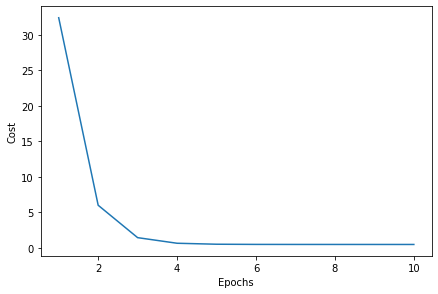

In [26]:
#看模型的迭代情况
import matplotlib.pyplot as plt

plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel("Epochs")
plt.ylabel("Training Cost")
plt.show()

In [32]:
#预测函数
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net,
                      feed_dict={model.X: X_test})
    return y_pred

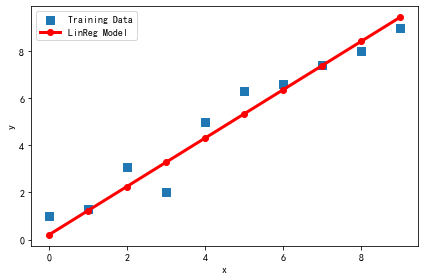

In [34]:
plt.scatter(X_train, y_train, marker='s', s=50,
            label="Training Data")
plt.plot(X_train, predict_linreg(sess, lrmodel, X_train),
         color='red', marker='o',
         markersize=6, linewidth=3,
         label="LinReg Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## 使用tensorflow的高级API高效率的训练神经网络

In [38]:
#训练手写识别数字数据
minist = np.load("data/mnist_scaled.npz")
X_train_centered, y_train, X_test_centered, y_test = [minist[i] for i in minist]

In [47]:
n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)
g = tf.Graph()  #创建计算图
with g.as_default():
    tf.set_random_seed = random_seed
    tf_x = tf.placeholder(dtype=tf.float32,  #输入x
                          shape=(None, n_features),
                          name="tf_x")
    tf_y = tf.placeholder(dtype=tf.int32,  #输入y
                          shape=None,
                          name="tf_y")
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)  #将y转换编码，多分类模型
    h1 = tf.layers.dense(inputs=tf_x, units=50,  #输入层
                         activation=tf.tanh,
                         name='layer1')
    h2 = tf.layers.dense(inputs=h1, units=50,  #隐藏层
                         activation=tf.tanh,
                         name='layer2')
    logits = tf.layers.dense(inputs=h2, units=10,  #输出层
                             activation=None,
                             name='layer3')
    predictions = {
        'classes': tf.argmax(logits, axis=1,
                             name='predicted_classes'),
        'probabilities': tf.nn.softmax(logits,
                                       name='softmax_tensor')
    }

/var/folders/b6/sj0f93ps3rn4fdfsd4mkgj_00000gn/T/ipykernel_1960/3033739132.py:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h1=tf.layers.dense(inputs=tf_x,units=50,
/Users/apple/opt/anaconda3/envs/Deep-Learning/lib/python3.10/site-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/var/folders/b6/sj0f93ps3rn4fdfsd4mkgj_00000gn/T/ipykernel_1960/3033739132.py:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h2=tf.layers.dense(inputs=h1,units=50,
/var/folders/b6/sj0f93ps3rn4fdfsd4mkgj_00000gn/T/ipykernel_1960/3033739132.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits=tf.la

In [54]:
#定义成本函数
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(
        onehot_labels=y_onehot, logits=logits
    )
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate=0.001
    )
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.global_variables_initializer()


#定义一个函数生成大批量数据
def creat_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i + batch_size, :], y_copy[i:i + batch_size])


##初始化tensorflow的变量并开始训练
sess = tf.Session(graph=g)

sess.run(init_op)

##迭代50次,每一次迭代都是将原始数据分成64小份的数据集进行计算，每一次迭代算出所有小份数据集的平均损失
for epoch in range(50):
    training_costs = []
    batch_generator = creat_batch_generator(  #该函数返回的是一个生成器
        X_train_centered, y_train, batch_size=64
    )
    for batch_X, batch_y in batch_generator:  #每次调用生成器，就是产生64大小的小份数据集，用该小份数据集训练模型
        feed = {tf_x: batch_X, tf_y: batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
    print('--Epoch %2d Avg.Training Loss: %.4f' % (epoch + 1, np.mean(training_costs)))

--Epoch  1 Avg.Training Loss: 1.8044
--Epoch  2 Avg.Training Loss: 1.1731
--Epoch  3 Avg.Training Loss: 0.8922
--Epoch  4 Avg.Training Loss: 0.7282
--Epoch  5 Avg.Training Loss: 0.6273
--Epoch  6 Avg.Training Loss: 0.5601
--Epoch  7 Avg.Training Loss: 0.5120
--Epoch  8 Avg.Training Loss: 0.4760
--Epoch  9 Avg.Training Loss: 0.4478
--Epoch 10 Avg.Training Loss: 0.4252
--Epoch 11 Avg.Training Loss: 0.4065
--Epoch 12 Avg.Training Loss: 0.3908
--Epoch 13 Avg.Training Loss: 0.3773
--Epoch 14 Avg.Training Loss: 0.3655
--Epoch 15 Avg.Training Loss: 0.3552
--Epoch 16 Avg.Training Loss: 0.3459
--Epoch 17 Avg.Training Loss: 0.3376
--Epoch 18 Avg.Training Loss: 0.3301
--Epoch 19 Avg.Training Loss: 0.3232
--Epoch 20 Avg.Training Loss: 0.3168
--Epoch 21 Avg.Training Loss: 0.3109
--Epoch 22 Avg.Training Loss: 0.3055
--Epoch 23 Avg.Training Loss: 0.3004
--Epoch 24 Avg.Training Loss: 0.2956
--Epoch 25 Avg.Training Loss: 0.2911
--Epoch 26 Avg.Training Loss: 0.2868
--Epoch 27 Avg.Training Loss: 0.2827
-

In [55]:
feed = {tf_x: X_test_centered, tf_y: y_test}
y_pred = sess.run(predictions['classes'], feed_dict=feed)
print("Test Accuracy:%2.f%%" % (100 * np.sum(y_pred == y_test) / y_test.shape[0]))

Test Accuracy:93%


## 用keras研发多层神经网络

In [57]:
minist = np.load("data/mnist_scaled.npz")
X_train_centered, y_train, X_test_centered, y_test = [minist[i] for i in minist]
n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)
import tensorflow.keras as keras

In [70]:
#用keras自带的onehot转换编码
tf.set_random_seed = random_seed
y_train_onehot = keras.utils.to_categorical(y_train)
model = keras.models.Sequential()
model.add(
    keras.layers.Dense(
        units=50,
        input_dim=X_train_centered.shape[1],
        kernel_initializer='zeros',
        activation='tanh'
    )
)
model.add(
    keras.layers.Dense(
        units=50,
        input_dim=50,
        kernel_initializer='glorot_uniform',  #权重矩阵的初始化算法
        bias_initializer='zeros',
        activation='tanh'
    )
)
model.add(
    keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='softmax'
    )
)
sgd_optimizer = keras.optimizers.SGD(
    lr=0.001, decay=1e-7, momentum=0.9
)
model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy')  #二分类变量的损失熵作为损失函数

/Users/apple/opt/anaconda3/envs/Deep-Learning/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [71]:
history = model.fit(X_train_centered, y_train_onehot,
                    batch_size=64,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/50
844/844 [==============================] - 5s 4ms/step - loss: 0.6479 - val_loss: 0.3371
Epoch 2/50
844/844 [==============================] - 3s 4ms/step - loss: 0.3538 - val_loss: 0.2606
Epoch 3/50
844/844 [==============================] - 3s 4ms/step - loss: 0.2964 - val_loss: 0.2307
Epoch 4/50
844/844 [==============================] - 3s 4ms/step - loss: 0.2633 - val_loss: 0.2108
Epoch 5/50
844/844 [==============================] - 3s 4ms/step - loss: 0.2392 - val_loss: 0.1901
Epoch 6/50
844/844 [==============================] - 3s 4ms/step - loss: 0.2210 - val_loss: 0.1788
Epoch 7/50
844/844 [==============================] - 3s 4ms/step - loss: 0.2056 - val_loss: 0.1684
Epoch 8/50
844/844 [==============================] - 3s 4ms/step - loss: 0.1933 - val_loss: 0.1591
Epoch 9/50
844/844 [==============================] - 3s 4ms/step - loss: 0.1824 - val_loss: 0.1508
Epoch 10/50
844/844 [==============================] - 3s 4ms/step - loss: 0.1726 - val_loss: 0.1450

In [76]:
#查看准确率，predict_classes函数已经被移除
y_train_pred = np.argmax(model.predict(X_train_centered, verbose=0), axis=1)
print('First 3 predictions: ', y_train_pred[:3])

y_train_pred = np.argmax(model.predict(X_train_centered,
                                       verbose=0), axis=1)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]

print('First 3 predictions: ', y_train_pred[:3])
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = np.argmax(model.predict(X_test_centered,
                                      verbose=0), axis=1)

correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

First 3 predictions:  [5 0 4]
First 3 predictions:  [5 0 4]
Training accuracy: 98.72%
Test accuracy: 97.21%


## 激活函数的选择
![](picture/逻辑函数.png)

In [5]:
import numpy as np
X=np.array([1,1.4,2.5])
w=np.array([0.4,0.3,0.5])
def net_input(X,w):
    return np.dot(X,w)

def logistic(z):
    return 1/(1+np.exp(-z))

def logistic_activation(X,w):
    z=net_input(X,w)
    return logistic(z)

print("P(y=1|x)=%.3f"%logistic_activation(X,w))

P(y=1|x)=0.888


In [9]:
#使用onehot编码后的输出值
W=np.array([[1.1,1.2,0.8,0.4],
           [0.2,0.4,1.0,1.2],
           [0.6,1.2,0.7,1.5]])
A=np.array([[1,0.1,0.4,0.6]])
Z=np.dot(W,A[0])
y_probs=logistic(Z)
print("Input Z:%s"%(Z))
print("Output:p:",y_probs)
#概率是没有意义的，因为不能理解为多分类的概率值，因为所有概率的和不等于1，但是如果只是用来找到分类的话那是可以的
print(np.argmax(y_probs))

Input Z:[1.78 1.36 1.9 ]
Output:p: [0.85569687 0.7957597  0.86989153]
2


![](picture/softmax.png)

In [11]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))
y_probs=softmax(Z)
print("Softmax p:",y_probs)
print(np.sum(y_probs))

Softmax p: [0.35912527 0.23596212 0.40491261]
1.0000000000000002


![](picture/双曲线.png)

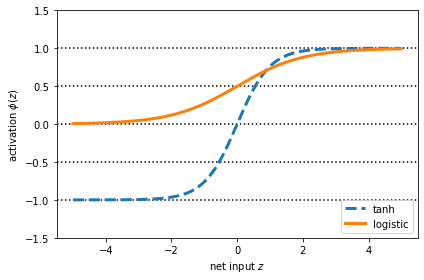

In [14]:
def tanh(z):
    e_p=np.exp(z)
    e_m=np.exp(-z)
    return (e_p-e_m)/(e_p+e_m)
import matplotlib.pyplot as plt
z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')#增加水平线
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')

plt.plot(z, tanh_act,
         linewidth=3, linestyle='--',
         label='tanh')

plt.plot(z, log_act,
         linewidth=3,
         label='logistic')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('images/13_03.png')
plt.show()
#np.tanh#现成的双曲正切函数
#from scipy import expit#现成的logi函数

![](picture/relu.png)
![](picture/激活函数.png)

# 总结
## 这一章学会了如何使用开源的TensorFlow在深度学习中进行数值计算。虽然因为TensorFlow支持GPU所带来的额外复杂性使其用起来不如NumPy方便，但是它可以非常有效地定义和训练大型多层神经网络。同样你也学习了如何调用TensorFlow的API来构建复杂的机器学习和神经网络模型并有效地运行。我们首先探讨了TensorFlow的低级API编程。当为矩阵向量乘法编程并定义每个操作的细节时，调用低级API建模可能会很麻麻烦。然而好处是它允许研发人员组合这些基本操作以构建更复杂的模型。此外也讨论了TensorFlow如何利用GPU来加快大型神经网络训练和测试的计然后探索了两个高级API，用它们构建神经网络模型要比低级API容易得多。具体来说，使用TensorFlow的Layers和Keras建立多层神经网络，并学习如何使用这些API来建立模型。tanh、softmax、和ReLU。第12章从实现简单的多层感知器（MLP）识别MNIST手写图像数据集开始。而从零开始的底层实现有助于说明多层神经网络的核心概念，如正向和反向传播的神经网络，用NumPy训练神经网络非常低效而且不切合实际。